In [1]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import camb 
from camb import model, initialpower
import glob
import pylab as plty
from PIL import Image

%matplotlib inline


In [2]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [3]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = _parameters[0], ombh2 = _parameters[1], omch2 = _parameters[2], mnu = _parameters[3],
                   omk = _parameters[4], tau = _parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [4]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")

#PLots a map in the mollview projection 
def mollviewmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [5]:
#Adds random noise to each pixel on a map given a variance 
def noisemapfunc(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #returns an array consisiting of [map with added noise, array of the added noise]


In [6]:
#cls --> something
def cltoalm(_cls, _NSIDE): #does this manually - doesn't work
    _alms = []
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax): 
        if _cls[l] > 0:
            _alms.append(np.complex(np.random.normal(0,_cls[l]),0))        #set m=0, which is real
        else:
            _alms.append(np.complex(0,0))
        
        for m in range(l): #set positive m's
            if _cls[l] > 0 and _cls[m] > 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])))
            if _cls[l] > 0 and _cls[m] <= 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),0))
            if _cls[l] <= 0 and _cls[m] > 0:
                _alms.append(np.complex(0,np.random.normal(0,0.5*_cls[m])))
            else:
                _alms.append(np.complex(0,0))
    
    return _alms   

def hpcltoalm(_cls, _NSIDE): #Healpy generate alms given cls
    return hp.synalm(_cls, lmax = (3*_NSIDE) - 1, new = True)

def cltomap(_cls, _NSIDE):
    _alm = cltoalm(_cls, _NSIDE)
    return almtomap(_alm, _NSIDE)

def hpcltomap(_cls, _NSIDE):   #Healpy generate a map given a power spectrum
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [7]:
#map --> something
def maptocl(_map):
    return

def hpmaptocl(_map): #Generate a power spectrum given cls
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)))    #lmax = 3NSIDE -1 by default

def maptoalm(_map):
    _omegp = (4*np.pi)/len(_map)
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    _alm = []
    for l in range(_lmax):
        for m in range(l+1):
            _TpYlm = []
            for i in range(len(_map)):
                _TpYlm.append(_map[i]*np.conjugate(sphharm(m, l, i, _NSIDE)))
                    
            _alm.append(_omegp*sum(_TpYlm))
    
    return _alm


def hpmaptoalm(_map, _lmax): #Healpy generate alms from map. 
    return hp.map2alm(_map, _lmax)


In [80]:
#alm --> something
def almtocl(_alm,lmax): #not the same value as healpy
    _l = np.arange(lmax)
    _scaling = 1 / ((2*_l + 1))
    count = 0
    _new = []
    _cl = []
    for l in range(lmax):
        _new.append([])
        for m in range(l):
            if m == 0:
                _new[l].append(np.absolute(_alm[count])**2)
                count = count + 1
                
            if m > 0:
                _new[l].append(2*np.absolute(_alm[count])**2)
                count = count + 1
              
    for i in range(len(_new)):
        _cl.append(_scaling[i] * sum(_new[i]))
    
    return _cl

def hpalmtocl(_alms, _lmax): #Healpy estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

def almtomap(_alm, _NSIDE):# alm --> map 
    _map = []
    _Npix = 12*(_NSIDE)**2
    _lmax = (3*_NSIDE)
    _count1 = 0
    _newalm = []
    for i in range(_lmax+1):
        for j in np.arange(-i+1,i):
            if j < 0: #for negative m's
                _newalm.append(np.conj(_alm[_count1+abs(j)]))
            else:
                _newalm.append(_alm[_count1]) #for m >= 0  
                _count1 = _count1 + 1
    
    for i in range(_Npix):
        _sum = []
        _count = 0
        for l in range(_lmax+1):
            for m in np.arange(-l+1,l):
                _sum.append(_newalm[_count]*sphharm(m,l-1,i, _NSIDE))
                _count = _count + 1
        _map.append(sum(_sum))
    return _map



def almtomap_tf(_alm, _NSIDE): #alm --> map for tensorflow 
    _map = tf.constant([])
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = tf.constant([])
        _count = 0
        for l in range(_lmax+1):
            for m in range(l):
                _sum = tf.concat((_sum,[_alm[_count]*sphharm(m,l,i, _NSIDE)]), axis = 0)
                _count = _count + 1
        _map = tf.concat((_map,[sum(_sum)]), axis = 0)
    return tf.convert_to_tensor(_map)


def hpalmtomap(_alms, _NSIDE):
    return hp.alm2map(_alms, _NSIDE)

[(0.8674219359629624-1.3066139109373842j), (7.893002412056929-5.6417976710371365j), (7.893002412056932-5.641797671037132j), (0.8674219359629679-1.3066139109373927j), (2.725968026101525+11.098169802844565j), (-0.8802844011385803+1.4072948817827218j), (-12.287556024553727-1.2119477709403297j), (-2.782469787768767+6.629208879541007j), (-2.782469787768796+6.629208879541017j), (-12.287556024553686-1.2119477709403625j), (-0.8802844011385735+1.4072948817827124j), (2.7259680261015107+11.098169802844557j), (5.7100476483518+0j), (0.2770061771985348+3.8170073619968874j), (-13.449594659885934-7.276998698540378j), (5.961263801862219-3.9663252446833797j), (-17.35703983541446+0j), (5.96126380186223-3.966325244683349j), (-13.449594659885937-7.276998698540384j), (0.2770061771985375+3.8170073619968825j), (1.0108588699354588+12.671146117688266j), (-0.2667379531468175-4.902935214735299j), (1.8842781800618242-15.040611627328794j), (-4.642528709450505+10.983265285575273j), (-4.6425287094505325+10.9832652855

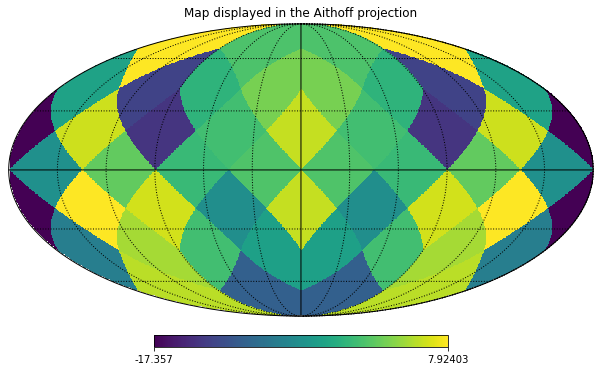

In [82]:
maptest = almtomap(noisealm4, int(lmax4/3))
mollviewmap(np.array(maptest))
print(maptest)

In [9]:
#healpy smoothing for the map and the alms
def hpmapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)

def hpalmsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

In [10]:
#splits/rejoins the alms into real/imaginary parts so that they can be optimised with scipy.optimize.minimize()
def singulartosplitalm(_alm):
    _realalm, _imagalm = _alm.real, _alm.imag
    return [_realalm, _imagalm]
    

def splittosingularalm(_realalm, _imagalm):
    _alm = []
    for i in range(len(_realalm)):
        _alm.append(complex(_realalm[i], _imagalm[i]))
    return _alm

def splittosingularalm_tf(_realalm, _imagalm): #takes the real and imaginary parts of the alms and creates a tensor
    return tf.complex(_realalm,_imagalm)

In [11]:
#Retrieves the spherical harmonics for a given, l, m and pixel number
def sphharm(m, l, _pixno, _NSIDE):
    _theta, _phi = hp.pix2ang(nside=_NSIDE, ipix=_pixno)
    return sp.special.sph_harm(m, l, _theta, _phi)
    

In [89]:
#negative log of the posterior, psi.
def psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _lncl, _realalm, _imagalm = [], [], []
    
    for i in range(len_cl):
        _lncl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _term1, _term2, _psi1 ,_psi2, _psi3 = [], [], [], [], [], []
    _sum = 0
    
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i]) #first term in the taylor paper 
    
    _l = np.arange(_lmax)
    for i in range(len(_lncl)):
        _psi2.append((_l[i] + 0.5)*(_lncl[i]))
    
    
    for i in range(len(_lncl)):
        _term1.append([])
        for j in range(i+1):
            if j == _sum:
                _term1[i].append(np.absolute(_a[_sum])**2)
            else:
                _term1[i].append(2*np.absolute(_a[_sum])**2)
            _sum = _sum + 1
            if j == i:
                _term2.append(sum(_term1[i])) 
    for i in range(len(_lncl)):
        _psi3.append(_term2[i]/(2*np.exp(_lncl[i])))
    
        
    _psi = sum(_psi1) + sum(_psi2) + sum(_psi3) #third term in the taylor paper
    print('psi =',_psi)
    return _psi

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

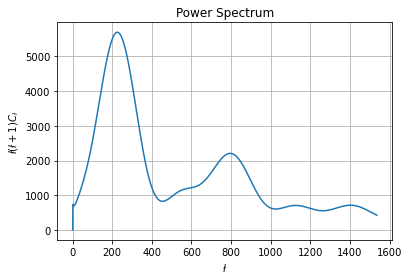

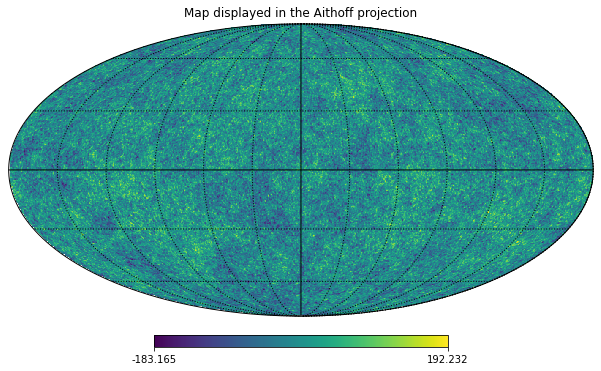

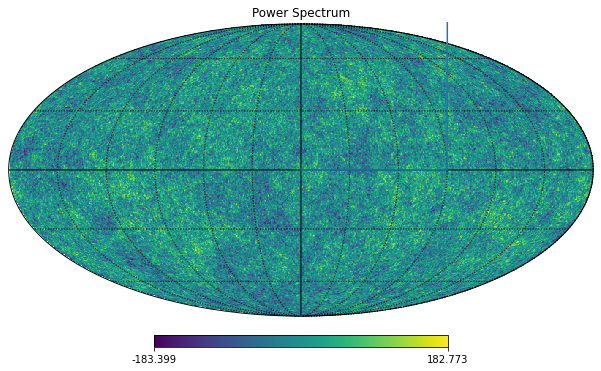

In [14]:
#Trial with parameters 1
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
NSIDE1 = int(lmax1/3)  #len(cls1)/3   #3*nside = len(cls)
n1 = np.linspace(5,5,(12*(NSIDE1)**2))
Ninv1 = []
for i in range(len(n1)):
    Ninv1.append(1/(n1[i]**2)) #finds the inverse noise matrix

cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
map1 = hpcltomap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = hpmapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
mollviewmap(map1) #plots the map
noisemap1 = noisemapfunc(list(map1),n1[0])[0] #adds noise to the map
mollviewmap(noisemap1) #plots the map with noise
alms1 = hpmaptoalm(noisemap1,lmax1) #computes the alms from the map with noise added.
CLestimate1 = hpalmtocl(alms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate1) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

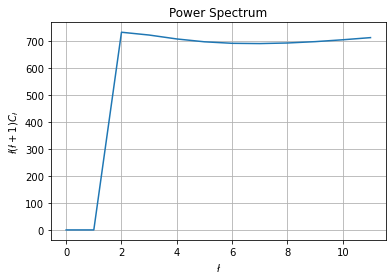

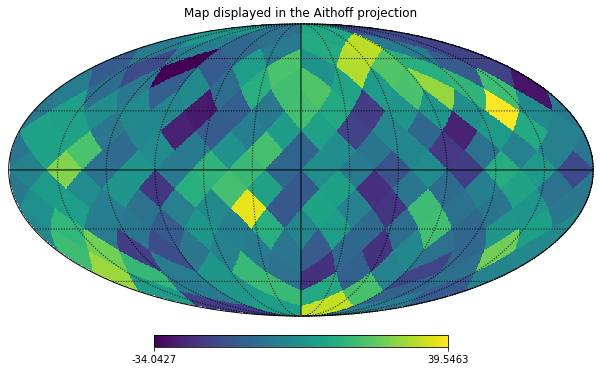

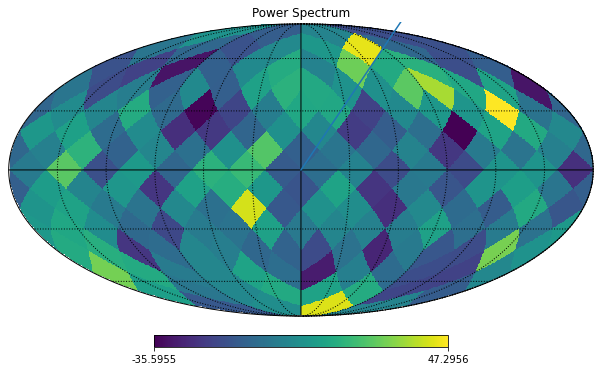

In [15]:
#Trial with parameters 2
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
NSIDE2 = int(lmax2/3)   #len(cls1)/3   #3*nside = len(cls)
n2 = np.linspace(5,5,(12*(NSIDE2)**2))
Ninv2 = []
for i in range(len(n2)):
    Ninv2.append(1/(n2[i]**2)) #finds the inverse noise matrix
    

cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
map2 = hpcltomap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = hpmapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
mollviewmap(map2) #plots the map
noisemap2 = noisemapfunc(map2,n2[0])[0] #adds noise to the map
mollviewmap(noisemap2) #plots the map with noise
alms2 = hpmaptoalm(noisemap2,lmax2) #computes the alms from the map with noise added.
CLestimate2 = hpalmtocl(alms2, lmax2) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate2) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

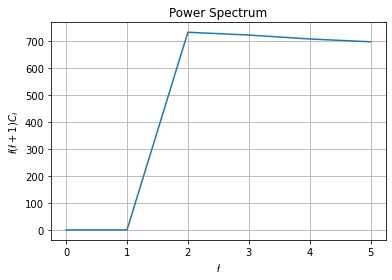

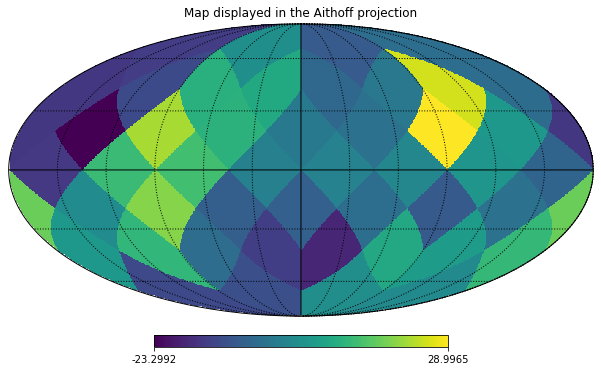

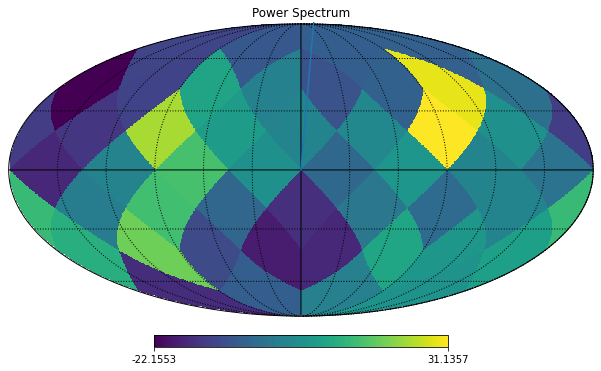

In [16]:
#Trial with parameters 3
parameters3 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax3 = 6  #lmax value wanted from data
NSIDE3 = int(lmax3/3)  #len(cls1)/3   #3*nside = len(cls)
n3 = np.linspace(5,5,(12*(NSIDE3)**2))
Ninv3 = []
for i in range(len(n3)):
    Ninv3.append(1/(n3[i]**2)) #finds the inverse noise matrix

cls3 = call_CAMB_map(parameters3, lmax3) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls3) #plot of the power spectrum.
map3 = hpcltomap(cls3, NSIDE3)  #generates a map from the power spectrum
map3 = hpmapsmooth(map3, lmax3) #applies a gaussian beam smoother to the map
mollviewmap(map3) #plots the map
noisemap3 = noisemapfunc(map3,n3[0])[0] #adds noise to the map
mollviewmap(noisemap3) #plots the map with noise
alms3 = hpmaptoalm(noisemap3,lmax3) #computes the alms from the map with noise added.
CLestimate3 = hpalmtocl(alms3, lmax3) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate3) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


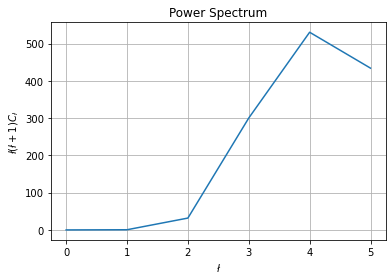

In [85]:
#Trial with parameters 4
parameters4 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax4 = 6  #lmax value wanted from data
NSIDE4 = int(lmax4/3)  #len(cls1)/3   #3*nside = len(cls)
n4 = np.linspace(5,5,(12*(NSIDE4)**2))
Ninv4 = []
for i in range(len(n4)):
    Ninv4.append(1/(n4[i]**2)) #finds the inverse noise matrix
    
cls4 = call_CAMB_map(parameters4, lmax4) #power spectrum for the given parameters and lmax.
map4 = hpcltomap(cls4, NSIDE4)  #generates a map from the power spectrum
map4 = hpmapsmooth(map4, lmax4) #applies a gaussian beam smoother to the map
noisemap4 = noisemapfunc(map4,n4[0])[0] #adds noise to the map

noisealm4 = np.array(maptoalm(noisemap4)) #recover cls from map
noisecl4 = almtocl(noisealm4, lmax4)
plotpwrspctrm(noisecl4) #plots the estimated power spectrum.


In [14]:
#inital values for the optimisation of psi (with the values from parameters4)
noisemap = noisemap4
clinit = noisecl4
realalminit = noisealm4.real
imagalminit = noisealm4.imag
x0 = []
len_cl = len(clinit)
len_ralm = len(realalminit)
len_ialm = len(imagalminit)
for i in range(len(clinit)):
    if clinit[i] > 0:
        x0.append(np.log(clinit[i]))
    else:
        x0.append(0)
for i in range(len(realalminit)):
    x0.append(realalminit[i])
for i in range(len(imagalminit)):
    x0.append(imagalminit[i])
print(x0)
print('psi_init = ',psi(x0,noisemap,lmax4,Ninv4))

[0, 1.5354522205845342, 4.216235408539795, 5.233568951473476, 4.691390782381222, 3.660316283082146, -3.732328324606466, 3.3120098278815484, -3.8900440519689536, 29.45879044093449, -5.725748078045209, 10.98866275780408, 15.400788578587013, 3.360848814523118, 3.131743198567998, 8.525345627532898, 5.03181652525968, -5.962590548268511, 2.0354620310202254, 3.5356537909957693, 6.89682319406194, 5.047540884783761, 2.368850390513535, -1.89426706016626, -0.9201827238876309, 2.0267497204066154, -3.845340271909006, 0.0, 0.0, -12.199486525147279, 0.0, -3.537952140787673, -7.4933369621684, 0.0, 15.469523647050275, -5.839036188705443, 2.1780162511755154, 0.0, 6.846639350782561, 2.7878361030313696, 0.4405207589623845, 6.8220407891765475, 0.0, 9.529086633741617, -7.977287345004423, 6.107784626495688, 1.7746426498683048, 9.903285906020987]
psi = 907.762176263355
psi_init =  907.762176263355


In [60]:
#Optimising the parameters of the posterior (the 'psi' funciton), to get the parameters corresponding to its min.
sp.optimize.fmin(psi, x0, args = (noisemap, lmax4, Ninv4), xtol=5)


psi = 1439.4845790574598
psi = 1439.4846844996493
psi = 1590.3309483759997
psi = 1436.1270759302515
psi = 1439.5972074241897
psi = 1440.2417206701207
psi = 1437.3337269374924
psi = 1439.5224886739984
psi = 1456.674132240433
psi = 1443.5923057422672
psi = 1444.979531366529
psi = 1441.2652798102988
psi = 1441.3995243258894
psi = 1441.9448932795121
psi = 1439.6817221060871
psi = 1439.7619906115392
psi = 1439.5185162912826
psi = 1439.4293875352914
psi = 1440.030621291865
psi = 1439.386257536925
psi = 1439.5027038892922
psi = 1439.5537951527488
psi = 1441.8008708444343
psi = 1439.4846371475228
psi = 1439.4807970410975
psi = 1440.5779412210252
psi = 1439.551850151526
psi = 1439.5345245167189
psi = 1439.484506252493
psi = 1439.483968277676
psi = 1516.6381538489204
psi = 1439.4848482651796
psi = 1440.6118963615763
psi = 1439.5878620974072
psi = 1439.4845053347228
psi = 1441.6271145347882
psi = 1440.4548721646047
psi = 1440.1841501630843
psi = 1439.484636669687
psi = 1439.5353037418856
psi = 14

psi = 818.3165374472862
psi = 817.0409189575727
psi = 813.5699635283383
psi = 813.6812913922123
psi = 811.4910804469987
psi = 810.5572906605158
psi = 809.82384122707
psi = 808.3825998779731
psi = 805.7545256849344
psi = 802.5837999656627
psi = 761.7940791098443
psi = 797.5739731834328
psi = 799.9146230561696
psi = 797.7548860912713
psi = 795.1167466434028
psi = 793.1618739010282
psi = 791.7100270528781
psi = 788.4267807650426
psi = 786.062221117572
psi = 783.7634642471277
psi = 781.4310223690202
psi = 779.0744537252478
psi = 777.8674753989798
psi = 775.3712512376576
psi = 774.9182447496669
psi = 772.7015260587757
psi = 771.8624560641078
psi = 770.1505472672368
psi = 766.6617936252788
psi = 764.831652127106
psi = 762.8437721488381
psi = 760.9785200394579
psi = 722.1077519488833
psi = 757.3872836795324
psi = 755.5105179641287
psi = 753.6732979914407
psi = 751.8726966330302
psi = 749.9907944205148
psi = 749.8368421929814
psi = 748.0292420956505
psi = 745.5911971046378
psi = 743.9386854953

psi = 469.0659947567373
psi = 468.4900023904916
psi = 468.3966803821754
psi = 468.57514362603956
psi = 467.4813052485573
psi = 468.09259681292815
psi = 467.54230169443827
psi = 467.03889589669177
psi = 465.6874908155858
psi = 469.29186937837517
psi = 466.29201371693057
psi = 467.4304300847782
psi = 465.421523148743
psi = 465.4302766285225
psi = 465.24960123627267
psi = 464.4345231709266
psi = 465.38509669579
psi = 464.3722443412983
psi = 464.9097225230901
psi = 464.05288711554357
psi = 459.1194352335972
psi = 463.5783747920872
psi = 463.1803080051516
psi = 463.2511602258643
psi = 462.6858719346784
psi = 462.1728869527622
psi = 462.8840929168589
psi = 462.4811431182718
psi = 461.6602466175253
psi = 461.61227230574036
psi = 461.449938923424
psi = 460.6819128801901
psi = 460.24951753089294
psi = 459.44823499236827
psi = 460.3011296563721
psi = 460.1599257088168
psi = 459.74860718029726
psi = 460.1931004211575
psi = 460.5368902764844
psi = 459.53761054722963
psi = 459.2614220949969
psi = 4

psi = 411.4561631784022
psi = 410.6049615842161
psi = 410.74804038025167
psi = 410.2690870149337
psi = 410.52043925889683
psi = 410.00129482779806
psi = 409.6849424002911
psi = 409.96101273847563
psi = 409.58667958722486
psi = 409.4116571839195
psi = 408.96379446047115
psi = 408.9850815551244
psi = 413.9154635627822
psi = 408.4781563875504
psi = 408.44379073789264
psi = 408.28412617490847
psi = 408.15641072348
psi = 408.16220190099165
psi = 407.8059444889319
psi = 407.47949686987715
psi = 407.1791816832716
psi = 406.9656029855216
psi = 402.8353771823406
psi = 407.32607281929046
psi = 407.8232914818883
psi = 406.80963109234466
psi = 406.5438595485994
psi = 407.16614028815775
psi = 406.38665280969514
psi = 406.13131836429034
psi = 405.98639686342193
psi = 409.1930466481396
psi = 405.6041554964099
psi = 405.62807630489715
psi = 405.3729789302416
psi = 405.04640539309753
psi = 405.38357895178933
psi = 404.7133156608116
psi = 404.91537803801975
psi = 404.54447066396256
psi = 404.61751472009

psi = 333.59364953832835
psi = 333.11446985718254
psi = 333.7407695965973
psi = 332.76923004240905
psi = 333.08950431555263
psi = 332.05070077807954
psi = 331.8789022297637
psi = 331.57663696607165
psi = 331.7910624966646
psi = 332.51965570301263
psi = 330.3772418443336
psi = 330.3387984980808
psi = 329.9887699821144
psi = 324.05002716554344
psi = 329.79727512737884
psi = 329.1350696065177
psi = 329.0178925061521
psi = 328.56954626042466
psi = 328.3531887341798
psi = 328.9811529730624
psi = 328.5346712053077
psi = 343.03932400261056
psi = 337.394500592936
psi = 328.4288592410567
psi = 329.35194055345335
psi = 327.65349088615505
psi = 327.4522459273717
psi = 326.67064490190705
psi = 326.2135390115466
psi = 326.91228479017155
psi = 327.33119364375113
psi = 326.2925588380565
psi = 326.3998142914988
psi = 324.9560913246986
psi = 324.69577815782725
psi = 324.7354747342487
psi = 328.28692053139883
psi = 331.42014663004215
psi = 325.8756652199411
psi = 323.72867618510907
psi = 319.14664936147

psi = 304.690193230486
psi = 304.6027901433334
psi = 305.3719561244938
psi = 304.57673255779486
psi = 304.4842982736277
psi = 304.0312095618473
psi = 304.0901003755026
psi = 305.6470009541239
psi = 304.513897962028
psi = 304.0980737316239
psi = 306.10132258384056
psi = 303.8234214099381
psi = 304.02562079031935
psi = 305.3985329996908
psi = 305.27851198019675
psi = 303.82681221046994
psi = 304.0693133889013
psi = 303.0127218661296
psi = 301.3162900617436
psi = 305.28278481482994
psi = 303.8687109869855
psi = 303.09299089159487
psi = 304.05172252486204
psi = 304.4926465068479
psi = 303.48275473778375
psi = 302.8379099009372
psi = 302.6886491489022
psi = 302.7341340172244
psi = 303.69662245180825
psi = 305.605832072815
psi = 302.5194430056022
psi = 303.6350702053594
psi = 302.7166429124595
psi = 303.4539769384006
psi = 302.3651071366962
psi = 303.0916264768484
psi = 302.15646112986866
psi = 303.2278922495116
psi = 302.35685526700985
psi = 304.8280676128374
psi = 304.65937023504017
psi = 

psi = 289.1008738294462
psi = 288.38447851760975
psi = 289.57454838076825
psi = 288.7559058072354
psi = 288.87987022120865
psi = 289.5263109372829
psi = 289.7009623435612
psi = 288.76499485789566
psi = 288.96018319518595
psi = 289.0642696753475
psi = 287.55063446437737
psi = 287.6773964456826
psi = 289.3614694857865
psi = 289.37986598152474
psi = 287.7703581691917
psi = 287.86721274974013
psi = 287.2697035253014
psi = 287.99785231936306
psi = 287.4610724548944
psi = 288.9786501590242
psi = 286.8181081502726
psi = 288.84893273040086
psi = 286.6407764698502
psi = 286.7061457848115
psi = 287.85241019156587
psi = 287.204420781306
psi = 287.8636511007311
psi = 289.7027170413418
psi = 288.17576167080415
psi = 288.5016117265245
psi = 287.5286601959267
psi = 286.3402949623335
psi = 285.98001266431754
psi = 287.7040171364461
psi = 288.7723000231413
psi = 287.39729787680864
psi = 287.6986193288995
psi = 288.2693204239264
psi = 288.72603054922064
psi = 286.40046301848463
psi = 286.71844220728775


psi = 275.6813289118442
psi = 274.10085549680326
psi = 279.0428955367115
psi = 278.05164772733633
psi = 277.27806873290126
psi = 277.204717578679
psi = 277.5197455989288
psi = 278.0236856477779
psi = 276.36286164932244
psi = 276.378401689919
psi = 275.94821531520665
psi = 276.72223998858857
psi = 278.11827726794814
psi = 276.5733595019619
psi = 278.76926237476187
psi = 278.4044002814465
psi = 277.2608340844119
psi = 278.34298991148853
psi = 278.2624011109361
psi = 276.8467221262593
psi = 277.8010758627931
psi = 277.5668296875963
psi = 276.32925913946195
psi = 276.13700914345964
psi = 275.81865270330997
psi = 277.99835307293523
psi = 275.29921650605786
psi = 277.74943867056015
psi = 277.3640487360896
psi = 277.72301493274665
psi = 275.6820149063772
psi = 278.23357273694944
psi = 275.4929956651804
psi = 275.30146164181485
psi = 276.02009696933965
psi = 277.06277185180636
psi = 276.20863731078566
psi = 274.89280926703
psi = 276.7572746512011
psi = 276.8292447881731
psi = 277.6153006249031

psi = 268.72621071608296
psi = 269.16861498691276
psi = 268.8556648133439
psi = 267.74630911128753
psi = 270.0601149137357
psi = 268.2787503353784
psi = 269.81876730787934
psi = 268.4620328694534
psi = 269.64179627503484
psi = 270.91473948839786
psi = 268.4982716312695
psi = 268.3441862975204
psi = 268.2002303717019
psi = 269.50232075355217
psi = 268.64153035733966
psi = 267.35931916414546
psi = 267.9911132070623
psi = 269.29873202246586
psi = 269.23320220878065
psi = 268.59600764430485
psi = 268.94683005945643
psi = 267.178544584445
psi = 268.888552742643
psi = 267.15856650732695
psi = 267.1976551095041
psi = 269.28948414243973
psi = 266.84889448816176
psi = 268.10183821496685
psi = 269.06100171345196
psi = 268.7869972558379
psi = 269.5117779960516
psi = 267.9853190419486
psi = 269.4467166603059
psi = 268.0156660818721
psi = 266.7278211613559
psi = 267.4739169836598
psi = 267.01718852036976
psi = 267.05775862707526
psi = 269.35897443951757
psi = 267.7780638587353
psi = 270.20563733332

psi = 259.8819324394051
psi = 261.11981588714093
psi = 261.524712012702
psi = 259.68201702788315
psi = 260.88767033149986
psi = 260.7769210365516
psi = 260.48745619878343
psi = 260.1208326464572
psi = 260.9037831382258
psi = 260.24897376387855
psi = 260.52035885468666
psi = 261.08016057787927
psi = 261.715632402334
psi = 259.43304611151683
psi = 260.89455907025734
psi = 261.43540700537176
psi = 259.5229844667816
psi = 260.20437323434675
psi = 261.04257529733684
psi = 260.1854355643526
psi = 261.25570809586225
psi = 259.6432748112048
psi = 261.40818660728723
psi = 259.64117697367817
psi = 260.2800505292862
psi = 258.50188835048147
psi = 261.40404826323953
psi = 258.2515659191698
psi = 260.8405784745723
psi = 258.2963678529377
psi = 261.152886526511
psi = 259.4210508674456
psi = 259.9312874238681
psi = 260.52317742076525
psi = 260.92582265251167
psi = 259.3012389985403
psi = 260.61999088391656
psi = 260.52223288766004
psi = 261.93024838703684
psi = 259.3117183844455
psi = 260.49291463231

psi = 255.58405598893108
psi = 254.4536814413652
psi = 254.20034328612036
psi = 255.77561698601158
psi = 254.57532452607185
psi = 255.43726736702098
psi = 255.27867025954438
psi = 255.1845395069036
psi = 254.56457039251717
psi = 255.37149060517527
psi = 255.70888314381943
psi = 254.60412737639578
psi = 255.46370032161855
psi = 254.36029709990854
psi = 254.88071002057683
psi = 255.45565919974976
psi = 254.61169014880187
psi = 253.81218389623697
psi = 254.9922218198761
psi = 255.41846990509302
psi = 254.49037162353324
psi = 254.7236325316952
psi = 255.5730510965874
psi = 254.40613463569474
psi = 254.98312495463034
psi = 254.15307907172578
psi = 254.2894267507177
psi = 255.34361586444246
psi = 254.42634280060622
psi = 255.91443750751375
psi = 254.3528505927618
psi = 254.01285158959067
psi = 255.26629912687523
psi = 254.39627794851518
psi = 255.21102222473675
psi = 254.46866084220537
psi = 254.74102874142963
psi = 253.99246090598552
psi = 255.06952581502526
psi = 254.19095978870405
psi = 2

psi = 251.07321709183512
psi = 251.29979184805111
psi = 250.36847444049377
psi = 250.7658968067873
psi = 251.65568620363777
psi = 250.84848199755754
psi = 251.41915989017673
psi = 251.7791420660755
psi = 250.76766733627164
psi = 250.69753241534409
psi = 251.2318089613827
psi = 251.54361432426253
psi = 250.70838534610144
psi = 250.85849557809604
psi = 250.20772367613614
psi = 250.93847659872193
psi = 250.53312041390515
psi = 251.00723446567412
psi = 250.4684389312301
psi = 250.40477418785838
psi = 251.1196942061005
psi = 251.19891971969236
psi = 250.93215313066324
psi = 250.7620892291713
psi = 251.71645884134455
psi = 250.46906184818346
psi = 250.00247459857633
psi = 250.75477149194325
psi = 250.14015470328417
psi = 249.81847468257914
psi = 250.17374445824382
psi = 250.92104758211462
psi = 250.79268971039315
psi = 251.0377392139533
psi = 250.84369607631845
psi = 250.69154789336918
psi = 251.14258672295588
psi = 250.16971521101993
psi = 251.05904847197218
psi = 250.64678731801138
psi = 2

psi = 248.83903472476987
psi = 249.02203349417263
psi = 248.73539910873134
psi = 249.1962228356731
psi = 248.83977895420435
psi = 248.6397388828663
psi = 248.77659150919212
psi = 248.70537366481815
psi = 248.9039624164916
psi = 248.98094371049893
psi = 248.70722739215162
psi = 248.66905256243945
psi = 248.67491554779528
psi = 248.9763698362213
psi = 249.1434329555527
psi = 248.79023517411338
psi = 248.98197851970193
psi = 248.81640509435198
psi = 249.06899248319695
psi = 248.79419596422994
psi = 248.74251559206743
psi = 249.0859350151889
psi = 248.79504550085278
psi = 248.71928158037184
psi = 248.6635597136077
psi = 248.91465584722275
psi = 248.631280456104
psi = 248.94235435962437
psi = 248.88022667269195
psi = 248.7618874145938
psi = 248.93723817108793
psi = 248.65936818926863
psi = 248.72725724755577
psi = 248.62021842981437
psi = 248.95142216997615
psi = 248.5981675563175
psi = 248.96747131361897
psi = 248.89431493613762
psi = 248.58284073632927
psi = 248.90438522198065
psi = 248.6

psi = 247.5904305095783
psi = 247.62735945442768
psi = 247.93367164429944
psi = 247.66595094496503
psi = 247.69015817410153
psi = 247.7235071722866
psi = 247.9090885925654
psi = 247.69598348970095
psi = 247.52467849143108
psi = 247.7457298892
psi = 247.49512881392877
psi = 247.43226178935447
psi = 247.86694791978397
psi = 247.7119661573112
psi = 247.43900567817863
psi = 247.58172632726087
psi = 247.9052128557522
psi = 247.5503606656309
psi = 247.91097667240652
psi = 247.69491809876195
psi = 247.6171904392313
psi = 247.77802823099466
psi = 247.57516731070743
psi = 247.53308218274682
psi = 247.4818392865962
psi = 247.5543965299779
psi = 247.46960306654134
psi = 247.6898431182392
psi = 247.70047964105592
psi = 247.46412931139258
psi = 247.6254131602485
psi = 247.45691518523265
psi = 247.50558766926042
psi = 247.60638218207964
psi = 247.38629326617115
psi = 247.3263704659808
psi = 247.3440059598462
psi = 247.51241640593844
psi = 247.39202661125785
psi = 247.39208378451127
psi = 247.6705231

psi = 245.69491354061867
psi = 245.83978049999186
psi = 245.84753033809136
psi = 245.81741312840785
psi = 245.91465712642338
psi = 245.68827750143817
psi = 245.55649983006336
psi = 245.66793423600208
psi = 245.5414147022186
psi = 245.64985596340532
psi = 245.74358903845712
psi = 245.625885456702
psi = 245.71730947135478
psi = 245.75291332611147
psi = 245.92432251885833
psi = 245.65901393054733
psi = 245.64646739106158
psi = 245.62406217773164
psi = 245.893712449709
psi = 245.65935846213918
psi = 245.4662563801313
psi = 245.44007462467104
psi = 245.767104705393
psi = 245.77529956967598
psi = 245.7635241181289
psi = 245.52799257313353
psi = 245.681678451541
psi = 245.68873691415828
psi = 245.7567070931833
psi = 245.68523457736293
psi = 245.4992153415931
psi = 245.5792958998882
psi = 245.72275274146426
psi = 245.66692297372316
psi = 245.64284308123084
psi = 245.7070375538304
psi = 245.51315155464926
psi = 245.8192899978052
psi = 245.5986926763369
psi = 245.50031840910958
psi = 245.7673542

psi = 244.4211434827005
psi = 244.6472082583291
psi = 244.63411152651082
psi = 244.54195699371297
psi = 244.71771080141002
psi = 244.497419135537
psi = 244.72039177154323
psi = 244.51153945665015
psi = 244.63129662009436
psi = 244.61073725872566
psi = 244.6586018615303
psi = 244.5710458115155
psi = 244.8041826774937
psi = 244.55741037444895
psi = 244.63450540340946
psi = 244.45994821993588
psi = 244.4914105984493
psi = 244.57409170837477
psi = 244.47007978514196
psi = 244.43950591405937
psi = 244.38797187319176
psi = 244.24851506457733
psi = 244.48011030584095
psi = 244.42820959108533
psi = 244.37010959396153
psi = 244.68917986380956
psi = 244.54623351592693
psi = 244.33211908136838
psi = 244.34146877313955
psi = 244.52497602257043
psi = 244.51707196185993
psi = 244.31352839367133
psi = 244.33646111283426
psi = 244.32170615671023
psi = 244.377499287522
psi = 244.33229588030576
psi = 244.29569766046663
psi = 244.3202960893522
psi = 244.51338445310626
psi = 244.46295064600466
psi = 244.3

psi = 242.45419240021675
psi = 242.70822939633055
psi = 242.48844681345147
psi = 242.64820588199223
psi = 242.47302156202753
psi = 242.59635981980367
psi = 242.51700014832045
psi = 242.59107623427505
psi = 242.57411453574903
psi = 242.58226933051372
psi = 242.57660279333618
psi = 242.60680152996855
psi = 242.46218396247798
psi = 242.51544818641202
psi = 242.49273952611458
psi = 242.57176624981454
psi = 242.57365113748995
psi = 242.60294008070863
psi = 242.46595980964477
psi = 242.58735151325467
psi = 242.46519088032093
psi = 242.61841923674527
psi = 242.45893820693715
psi = 242.5788215071533
psi = 242.45842164197705
psi = 242.5986477365194
psi = 242.4536309284686
psi = 242.50326428419046
psi = 242.46092149033663
psi = 242.47608526706887
psi = 242.70228396350902
psi = 242.4451386632975
psi = 242.6495146347158
psi = 242.44407197321073
psi = 242.4732617741486
psi = 242.66457657328746
psi = 242.43340271061982
psi = 242.47569140616497
psi = 242.65727719129492
psi = 242.44620798050718
psi = 

psi = 242.37889055375027
psi = 242.366542884363
psi = 242.37578986877193
psi = 242.3701788050574
psi = 242.36957841428168
psi = 242.38074011747037
psi = 242.36599771678337
psi = 242.3709634032208
psi = 242.3719982828186
psi = 242.37307481646013
psi = 242.36610331483638
psi = 242.3730229759267
psi = 242.36043417965647
psi = 242.37765305714984
psi = 242.36487986949794
psi = 242.35242056446663
psi = 242.3749173669282
psi = 242.35282867627367
psi = 242.3625442880588
psi = 242.35270212273574
psi = 242.368280877896
psi = 242.37127649496264
psi = 242.3742099818955
psi = 242.3568392463721
psi = 242.36374205726506
psi = 242.3478709867107
psi = 242.3601862951262
psi = 242.3497854301365
psi = 242.36978614333674
psi = 242.3495350480427
psi = 242.35810337628146
psi = 242.35428503573152
psi = 242.35568927579635
psi = 242.36704506455973
psi = 242.36569587504334
psi = 242.3639749138323
psi = 242.35282685525624
psi = 242.3567579798722
psi = 242.35498133983427
psi = 242.36939105263087
psi = 242.36872643

psi = 242.09703601888555
psi = 242.1109747257618
psi = 242.1052965615486
psi = 242.08588792942453
psi = 242.0993018687867
psi = 242.0882321542307
psi = 242.10681714378325
psi = 242.08916224782052
psi = 242.08687411290282
psi = 242.0888518921928
psi = 242.09528080961547
psi = 242.08005505380277
psi = 242.07815255772186
psi = 242.09046924158756
psi = 242.1123526578587
psi = 242.07615424035134
psi = 242.07631720597976
psi = 242.0673677044289
psi = 242.0547138007759
psi = 242.05950084138024
psi = 242.11233438092663
psi = 242.05859770019717
psi = 242.06115310677174
psi = 242.06795220908197
psi = 242.08847876533332
psi = 242.09897754604822
psi = 242.05412147477585
psi = 242.0366499841494
psi = 242.05975109416974
psi = 242.1097741157275
psi = 242.05715535221174
psi = 242.0376394000134
psi = 242.0590827395286
psi = 242.04137023961337
psi = 242.03939036677642
psi = 242.05401481134032
psi = 242.0418956035416
psi = 242.06941945089937
psi = 242.05353195545854
psi = 242.0390867379358
psi = 242.0352

psi = 241.8127629773483
psi = 241.81725063852943
psi = 241.80616399544778
psi = 241.81117758746535
psi = 241.80100962309342
psi = 241.81063664969113
psi = 241.81970196097868
psi = 241.8070290055425
psi = 241.8249427654293
psi = 241.8063265611583
psi = 241.82095933476188
psi = 241.80671886353556
psi = 241.80782207790085
psi = 241.8157205444668
psi = 241.8214841496746
psi = 241.80642194055036
psi = 241.80594374391399
psi = 241.8112896680066
psi = 241.81832754886298
psi = 241.8062810605013
psi = 241.80253289184762
psi = 241.82389876256042
psi = 241.8054632342538
psi = 241.81782508935612
psi = 241.80601795594168
psi = 241.81540080666852
psi = 241.80593087029376
psi = 241.7982472561922
psi = 241.80196044652482
psi = 241.81029974752323
psi = 241.80211731752235
psi = 241.80839463231175
psi = 241.79679602029304
psi = 241.79943989410384
psi = 241.80418359708386
psi = 241.80574245535604
psi = 241.7968699039576
psi = 241.80361915103583
psi = 241.8149684537426
psi = 241.8036018263346
psi = 241.809

psi = 241.65045454934238
psi = 241.658218472319
psi = 241.66080631781705
psi = 241.64387812073556
psi = 241.6421410308629
psi = 241.64126618766085
psi = 241.63645345272053
psi = 241.63087064843006
psi = 241.60879757911033
psi = 241.6418816224467
psi = 241.6442529007321
psi = 241.6331339256374
psi = 241.65809569602675
psi = 241.64781772847613
psi = 241.6266490225951
psi = 241.62999212718861
psi = 241.62533653732984
psi = 241.6376840270182
psi = 241.63435357844415
psi = 241.62338690275013
psi = 241.6276740288588
psi = 241.62678041533403
psi = 241.63095938333592
psi = 241.62438116049194
psi = 241.62779228353142
psi = 241.6227147236104
psi = 241.62196784282756
psi = 241.62473377555182
psi = 241.62114564080753
psi = 241.6048408016344
psi = 241.581023080884
psi = 241.62094501241359
psi = 241.6044505912283
psi = 241.60029685560684
psi = 241.60446572374022
psi = 241.61976443358114
psi = 241.60446229749553
psi = 241.62144514449164
psi = 241.61286937654833
psi = 241.60168152124066
psi = 241.6056

psi = 241.2660507905378
psi = 241.2672669402981
psi = 241.2737122481916
psi = 241.29424497991374
psi = 241.24228873138264
psi = 241.24532591172115
psi = 241.275435082579
psi = 241.24422398506948
psi = 241.2743011923695
psi = 241.2886316370205
psi = 241.26234528063722
psi = 241.27028025899182
psi = 241.28532846764807
psi = 241.25923306056532
psi = 241.26416663688423
psi = 241.28446059068165
psi = 241.27892298285468
psi = 241.25637961819612
psi = 241.28654703615007
psi = 241.26364770362846
psi = 241.28665701722275
psi = 241.2606267238053
psi = 241.2691014828296
psi = 241.2865913688289
psi = 241.2605897581925
psi = 241.2466442200123
psi = 241.28718263729633
psi = 241.2585394596496
psi = 241.24656254877573
psi = 241.28174749195696
psi = 241.25713978130295
psi = 241.25047775627993
psi = 241.25506167262043
psi = 241.25962210053885
psi = 241.25770453725812
psi = 241.27380979818668
psi = 241.28873168074992
psi = 241.25429686404283
psi = 241.2579903723724
psi = 241.27010756848222
psi = 241.2737

psi = 241.20591677673363
psi = 241.20536474767087
psi = 241.2048383722945
psi = 241.20346139913752
psi = 241.2031961272715
psi = 241.2002173549304
psi = 241.21649208581005
psi = 241.20763669712872
psi = 241.2022901738707
psi = 241.20798813244372
psi = 241.2095779626475
psi = 241.21735753467027
psi = 241.21510926200673
psi = 241.21027422977448
psi = 241.21303197664992
psi = 241.20412342581244
psi = 241.20198260515636
psi = 241.21046790669436
psi = 241.20510051508865
psi = 241.20334642444521
psi = 241.20272779443175
psi = 241.202150262229
psi = 241.2011121236259
psi = 241.20012839691802
psi = 241.20109638180742
psi = 241.2074464957359
psi = 241.20909010014577
psi = 241.20900778336954
psi = 241.19833025956962
psi = 241.19824071721686
psi = 241.19952289166196
psi = 241.2034232930242
psi = 241.21328653602788
psi = 241.2053761962674
psi = 241.19877118599547
psi = 241.20398316642576
psi = 241.20069641855716
psi = 241.19611853711072
psi = 241.19794981404505
psi = 241.20337171571774
psi = 241.1

psi = 240.90257570300489
psi = 240.91342090685674
psi = 240.90314695956047
psi = 240.8956657836143
psi = 240.90187971811548
psi = 240.90328863972542
psi = 240.9321119363592
psi = 240.90939105573415
psi = 240.88808496106154
psi = 240.88807748528382
psi = 240.89324262334776
psi = 240.8892528951607
psi = 240.8904808747597
psi = 240.90181238651698
psi = 240.8899111457083
psi = 240.87567520877462
psi = 240.84787403213653
psi = 240.88990620065553
psi = 240.87946756397145
psi = 240.8835272868833
psi = 240.87361918839684
psi = 240.88362863621515
psi = 240.871229360668
psi = 240.86225568750768
psi = 240.86774691071872
psi = 240.8635545490682
psi = 240.84843065197808
psi = 240.8596494948021
psi = 240.86941875970746
psi = 240.85256843102655
psi = 240.84329389413446
psi = 240.8056799867621
psi = 240.8537277328289
psi = 240.8633261759694
psi = 240.8500799099408
psi = 240.84662512656647
psi = 240.83885470396368
psi = 240.87203572480337
psi = 240.83392587688627
psi = 240.8380880166596
psi = 240.83234

psi = 240.43915726150823
psi = 240.47007932665161
psi = 240.47167293133515
psi = 240.44918100218578
psi = 240.48297054919414
psi = 240.46864868185304
psi = 240.4536490711664
psi = 240.4498793374408
psi = 240.46892674272445
psi = 240.47889775912313
psi = 240.46774897946463
psi = 240.47395971214473
psi = 240.4493361063406
psi = 240.47160293041682
psi = 240.44203150867153
psi = 240.48430323660418
psi = 240.44593246044448
psi = 240.43201195095003
psi = 240.46239669127993
psi = 240.4284793655551
psi = 240.45239951650672
psi = 240.43345660264956
psi = 240.4504831962557
psi = 240.4539859828812
psi = 240.4439066755706
psi = 240.4314461987969
psi = 240.46490933411098
psi = 240.43484783564526
psi = 240.44023737834368
psi = 240.45394462108513
psi = 240.46470864252805
psi = 240.45428406066273
psi = 240.42213099120573
psi = 240.44114751266972
psi = 240.46770045820503
psi = 240.44616078399454
psi = 240.47031315244877
psi = 240.46095076496275
psi = 240.47403534306164
psi = 240.43523638280936
psi = 24

psi = 240.41268526974062
psi = 240.40863344006056
psi = 240.41156004071127
psi = 240.41035172433476
psi = 240.40831473651235
psi = 240.41463349141907
psi = 240.4121417782436
psi = 240.40818129271042
psi = 240.41453690034993
psi = 240.40880845554184
psi = 240.41208152475818
psi = 240.40837209275884
psi = 240.41151468751525
psi = 240.4112852666641
psi = 240.41132497339032
psi = 240.40835628315875
psi = 240.41172227732918
psi = 240.40833751955176
psi = 240.411952861769
psi = 240.4080681327477
psi = 240.41173854329313
psi = 240.4085499666515
psi = 240.41351048320422
psi = 240.4079876763809
psi = 240.413690117664
psi = 240.40799299267795
psi = 240.40898375489934
psi = 240.40892144692958
psi = 240.4083087060856
psi = 240.41218774355252
psi = 240.40795124294408
psi = 240.41189888599234
psi = 240.40794343199042
psi = 240.41085002000227
psi = 240.40789222683935
psi = 240.40865356066206
psi = 240.41045853611706
psi = 240.40781090919918
psi = 240.40948926183188
psi = 240.41207528475906
psi = 240.

psi = 240.40653574847678
psi = 240.40651239432597
psi = 240.4065169566739
psi = 240.40595495559904
psi = 240.40618331394933
psi = 240.40634504983038
psi = 240.40654544552686
psi = 240.40619417321457
psi = 240.40625648853535
psi = 240.40652551789276
psi = 240.40617184233253
psi = 240.405923078273
psi = 240.40597927297188
psi = 240.40578894420193
psi = 240.40576756817165
psi = 240.40649028351254
psi = 240.40612851950013
psi = 240.40573035886
psi = 240.4056287484647
psi = 240.40619689737917
psi = 240.40625389907677
psi = 240.40570663505463
psi = 240.40582273874358
psi = 240.40598210629972
psi = 240.4060909488594
psi = 240.40556434417397
psi = 240.40535951956076
psi = 240.40613994502553
psi = 240.4061876718878
psi = 240.40627517707227
psi = 240.40613714491303
psi = 240.40600184104852
psi = 240.4059518703333
psi = 240.40611442791868
psi = 240.40582609171904
psi = 240.40619803791145
psi = 240.4057687553519
psi = 240.40592656834392
psi = 240.40585512726682
psi = 240.4054977016891
psi = 240.40

psi = 240.39534444031347
psi = 240.3959666498771
psi = 240.39549346093415
psi = 240.3953267809616
psi = 240.3950873263635
psi = 240.39566523917287
psi = 240.39541272282185
psi = 240.3948167374127
psi = 240.3951653516553
psi = 240.3958949614974
psi = 240.39490670338742
psi = 240.3947499589381
psi = 240.39507585838854
psi = 240.39496368188583
psi = 240.39487811337077
psi = 240.39453363485492
psi = 240.39364884912695
psi = 240.39408009746546
psi = 240.3944025201704
psi = 240.39411038078276
psi = 240.3948431162471
psi = 240.3941785774048
psi = 240.39441815640848
psi = 240.39455721092938
psi = 240.3942059977187
psi = 240.39436464233967
psi = 240.39366625252882
psi = 240.3937375280876
psi = 240.39392569438698
psi = 240.39348564497107
psi = 240.39237389193485
psi = 240.39345730076207
psi = 240.39341942381282
psi = 240.3938016853029
psi = 240.3932301993526
psi = 240.39289814749637
psi = 240.39319249068822
psi = 240.39419625268437
psi = 240.3930342966178
psi = 240.39276141662282
psi = 240.39250

psi = 240.3555885110092
psi = 240.3570309755525
psi = 240.354979159067
psi = 240.35574989061217
psi = 240.35554976555858
psi = 240.35540888577788
psi = 240.35534301274643
psi = 240.35629823983442
psi = 240.35440960254707
psi = 240.35561714618154
psi = 240.35457645133886
psi = 240.35380681555642
psi = 240.3542835567374
psi = 240.35379808197277
psi = 240.35527681500227
psi = 240.35317401726695
psi = 240.34957917299772
psi = 240.35315882651153
psi = 240.3527564081418
psi = 240.35319223612572
psi = 240.35337636347046
psi = 240.35180284208428
psi = 240.35284601517773
psi = 240.35157387854838
psi = 240.35239634141888
psi = 240.35137130589015
psi = 240.35177724546793
psi = 240.35187232795275
psi = 240.35085469411067
psi = 240.35050109454875
psi = 240.3497483453558
psi = 240.3497430843493
psi = 240.34993658278623
psi = 240.3514901111668
psi = 240.35091625549998
psi = 240.3495670128109
psi = 240.34642651876288
psi = 240.3495737273875
psi = 240.34935125942056
psi = 240.34888723849068
psi = 240.3

array([ 6.65805386e-03, -1.14323316e+01,  2.85096623e+00,  2.24860173e+00,
        7.45467536e-01,  3.38051117e+00, -8.01696295e-01,  1.91720016e-04,
       -2.20591383e-05,  4.32627473e+00,  3.17000939e+00, -1.65206301e+00,
        7.16627495e-01, -4.91097830e-01, -8.51611855e-01,  2.98053878e+00,
       -5.65758867e-01,  6.11537792e-01,  1.57193909e+00, -5.51392460e-01,
       -8.46736869e-01, -2.88612098e+00,  1.60303750e-01, -3.43567567e-01,
        2.85585185e+00, -1.34349014e-01,  2.81123703e+00,  1.94146801e-02,
        5.47921572e-03, -7.59420514e-05, -3.89457308e-03,  7.09225719e-01,
       -1.17188284e+00, -4.39232510e-03,  2.72917372e+00,  2.22157871e+00,
        2.27200080e+00,  7.25360376e-03, -9.43449214e-01,  5.99959501e-01,
        1.89351072e+00, -3.46990467e-01,  9.79649465e-03, -1.84081215e+00,
        1.96236348e+00,  6.51432562e+00,  7.72416884e+00,  4.43505973e-01])

In [90]:
#psi for the final output parameters

x1 =   [1.82995366e-02,  1.97020448e+00,  1.83496854e-01,  2.36713545e+00,
        1.56260434e+00, -8.42027806e-01, -5.77585670e-01, -2.36115669e+00,
       -5.26334928e+00, -4.18258171e-01, -1.44557606e+00, -6.14849215e-01,
        2.36508671e+00, -2.03912329e+00, -7.63921564e+00,  1.10864542e+00,
       -4.39445321e-01,  4.52720803e-01,  1.79294385e+00, -2.75453224e-01,
       -3.02249792e+00,  5.18832600e-01, -3.29712055e-02, -1.14176786e+00,
       -4.73800982e-01, -4.24720732e-01, -4.16282758e-02, -9.87031861e-03,
        2.45457312e-02,  8.47701696e-01,  1.19812529e-02,  9.47577830e-01,
       -5.60395838e-01,  8.50181580e-03,  2.33257559e+00,  2.26875577e+00,
        4.45997679e+00,  1.23349469e-02, -4.29420599e-01,  5.84330431e-01,
        4.72826515e+00, -1.69849697e+00, -4.73555196e-03, -2.07454569e-01,
       -1.25604381e-01,  1.27407997e-01,  1.01223363e+00,  1.90823778e-01]

noisemap_tf = tf.convert_to_tensor(noisemap)

print('psi(x0)',psi(x0, noisemap, lmax4, Ninv4)) #printing the initial parameters psi value and the outputs. 
print('psi(x1)',psi(x1, noisemap, lmax4, Ninv4))

psi = (269.2611731976691-8.378998377117094j)
psi(x0) (269.2611731976691-8.378998377117094j)
psi = (369.17800628608404-7.180457938650418j)
psi(x1) (369.17800628608404-7.180457938650418j)


In [16]:
def multtensor(_lmax,_lenalm):
    _shape = np.zeros([_lmax,_lenalm]) #matrix for the calculation of the psi in psi_tf
    _count = 0
    for i in range(_lmax):
        for j in np.arange(0,i+1):
            if j == 0:
                _shape[i][_count] = 1.0
                _count = _count + 1
            else:
                _shape[i][_count] = 2.0
                _count = _count + 1
    return tf.convert_to_tensor(_shape, dtype = tf.float32)


In [25]:
abe11 = tf.constant([1.1,2.4,3.5])
abe12 = tf.constant([4.4,5.8,6.6])
abe1 = tf.complex(abe11,abe12)
abe2 = tf.constant([[1+2j,2-7j,3+0j],[1+2j,2-7j,3+0j],[1+2j,2-7j,3+0j]], dtype = tf.complex64)
print(abe1)
print(abe2)
print(tf.linalg.matvec(abe2,abe1))

tf.Tensor([1.1+4.4j 2.4+5.8j 3.5+6.6j], shape=(3,), dtype=complex64)
tf.Tensor(
[[1.+2.j 2.-7.j 3.+0.j]
 [1.+2.j 2.-7.j 3.+0.j]
 [1.+2.j 2.-7.j 3.+0.j]], shape=(3, 3), dtype=complex64)
tf.Tensor([48.2+21.199999j 48.2+21.199999j 48.2+21.199999j], shape=(3,), dtype=complex64)


In [86]:
def almtomap_tf2(_alm,_lmax):
    _NSIDE = int(_lmax/3)
    _Npix = _lmax**2*4/3
    _count = 0
    _newalm = tf.constant([], dtype = tf.complex64)
    for i in range(_lmax+1):
        for j in np.arange(-i+1,i):
            if j < 0: #for negative m's
                _newalm = tf.concat((_newalm,[tf.math.conj(_alm[_count+abs(j)])]), axis = 0)
            else:
                _newalm = tf.concat((_newalm, [_alm[_count]]),axis = 0) #for m >= 0  
                _count = _count + 1
    mat = _sph
    vec = _newalm
    #print('mat',_sph)
    #print('vec',_newalm)
    
    _result = np.matmul(mat.numpy(),vec.numpy())
    print('p',_result)
    #_result = tf.linalg.matvec(mat,vec) #linalg.matvec(_sph, _newalm)
    return tf.convert_to_tensor(_result)


_sph = []
for i in range(int(lmax4**2*4/3)):
    _sph.append([])
    for l in range(lmax4+1):
        for m in np.arange(-l+1,l):
            _theta, _phi = hp.pix2ang(nside=int(lmax4/3), ipix=i)
            _sph[i].append(sp.special.sph_harm(m, l-1, _theta, _phi))
_sph = tf.convert_to_tensor(_sph, dtype = np.complex64)
#_sph = tf.dtypes.cast(_sph, tf.complex64) 
print('sph',_sph)

sph tf.Tensor(
[[ 0.2820948 +0.j          0.22394282-0.09763564j  0.34549415+0.j
  ... -0.14170358-0.40394998j -0.019119  +0.2587524j
   0.03824358-0.07258969j]
 [ 0.2820948 +0.j          0.22394282-0.09763564j -0.34549415+0.j
  ... -0.14170358-0.40394998j  0.019119  -0.2587524j
   0.03824358-0.07258969j]
 [ 0.2820948 +0.j          0.22394282-0.09763564j -0.34549415+0.j
  ... -0.14170358-0.40394998j  0.019119  -0.2587524j
   0.03824358-0.07258969j]
 ...
 [ 0.2820948 +0.j         -0.22394282-0.09763564j -0.34549415+0.j
  ...  0.14170358-0.40394998j  0.019119  +0.2587524j
  -0.03824358-0.07258969j]
 [ 0.2820948 +0.j         -0.22394282-0.09763564j -0.34549415+0.j
  ...  0.14170358-0.40394998j  0.019119  +0.2587524j
  -0.03824358-0.07258969j]
 [ 0.2820948 +0.j         -0.22394282-0.09763564j  0.34549415+0.j
  ...  0.14170358-0.40394998j -0.019119  -0.2587524j
  -0.03824358-0.07258969j]], shape=(48, 36), dtype=complex64)


In [87]:
def psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax4, Ninv4
    #_map, _lmax, _Ninv = noisemap, lmax4, Ninv4
    _lncl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    
    _d = _map
    _a = splittosingularalm_tf(_realalm, _imagalm)
    _Ya = almtomap_tf2(_a, int(_lmax))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    
    _d = tf.dtypes.cast(_d, tf.float32) 
    _elem = _d - _BYa
    _psi1 = 0.5*(_elem**2)*_Ninv
    
    _l = tf.range(_lmax, dtype = tf.float32)
    _psi2 = (_l+0.5)*_lncl
    _a = tf.math.abs(_a)**2
    _as = tf.linalg.matvec(shape,_a)
    _psi3 = 0.5*_as/tf.math.exp(_lncl)
    
    _psi = tf.reduce_sum(_psi1) + tf.reduce_sum(_psi3) + tf.reduce_sum(_psi2) 
    print('psi =',_psi)   
    return -_psi


In [88]:
def run_chain1(initial_state, num_results=100, num_burnin_steps=50): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=hmc_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi_tf, step_size=0.1,
                                            num_leapfrog_steps=2) #, state_gradients_are_stopped = True)

shape = multtensor(lmax4,len_ralm)
x1_tf = tf.convert_to_tensor(x1) #inital guess
samples1, kernel_results1 = run_chain1(x1_tf) #Runs the chain
print("Acceptance rate:", kernel_results1.is_accepted.numpy().mean()) 


p [-6.1808357 -1.6923977e+00j  8.192135  +2.7207923e-01j
  8.192135  +2.7207923e-01j -6.1808357 -1.6923977e+00j
 -0.9030646 +2.0053105e+00j  0.3622625 +7.4639311e+00j
  3.6396744 +8.4598792e-01j -0.6246881 +5.5159223e-01j
 -0.6246881 +5.5159223e-01j  3.6396744 +8.4598792e-01j
  0.3622625 +7.4639311e+00j -0.9030646 +2.0053105e+00j
  0.29828304+2.9119944e-02j  1.2615454 +7.3542581e+00j
 -0.38144428+6.1259632e+00j -4.7380176 +9.9176687e-01j
 -1.8956027 +1.3042144e-03j -4.7380176 +9.9176687e-01j
 -0.38144428+6.1259632e+00j  1.2615454 +7.3542581e+00j
  1.5724254 +3.3290846e+00j  1.3498    +4.5711040e+00j
 -4.606483  +2.8086681e+00j -4.3025055 +2.6937757e+00j
 -4.3025055 +2.6937757e+00j -4.606483  +2.8086681e+00j
  1.3498    +4.5711040e+00j  1.5724254 +3.3290846e+00j
  0.29828304+2.9119944e-02j  3.2779095 +1.7568671e+00j
  1.5224767 -4.1624451e-01j -4.6001935 +4.6366639e+00j
 -1.8956027 +1.3042144e-03j -4.6001935 +4.6366639e+00j
  1.5224767 -4.1624451e-01j  3.2779095 +1.7568671e+00j
  0.5936

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a complex64 tensor [Op:Sub]

In [47]:
def run_chain2(_initial_state, num_results=100, num_burnin_steps=50):
    '''Uses HMC to step through parameter space with an adaptive step size.'''
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(hmc_kernel,
                                                        num_adaptation_steps=int(.8 * num_burnin_steps),
                                                        target_accept_prob=np.float32(.65))

    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                                 current_state=_initial_state, kernel=adaptive_kernel,
                                 trace_fn=lambda cs, kr: kr)

samples2, kernel_results2 = run_chain2(x1_tf)
print("Acceptance rate:", kernel_results2.inner_results.is_accepted.numpy().mean())

mat tf.Tensor(
[[ 0.2820948 +0.j          0.22394282-0.09763564j  0.34549415+0.j
  ... -0.14170358-0.40394998j -0.019119  +0.2587524j
   0.03824358-0.07258969j]
 [ 0.2820948 +0.j          0.22394282-0.09763564j -0.34549415+0.j
  ... -0.14170358-0.40394998j  0.019119  -0.2587524j
   0.03824358-0.07258969j]
 [ 0.2820948 +0.j          0.22394282-0.09763564j -0.34549415+0.j
  ... -0.14170358-0.40394998j  0.019119  -0.2587524j
   0.03824358-0.07258969j]
 ...
 [ 0.2820948 +0.j         -0.22394282-0.09763564j -0.34549415+0.j
  ...  0.14170358-0.40394998j  0.019119  +0.2587524j
  -0.03824358-0.07258969j]
 [ 0.2820948 +0.j         -0.22394282-0.09763564j -0.34549415+0.j
  ...  0.14170358-0.40394998j  0.019119  +0.2587524j
  -0.03824358-0.07258969j]
 [ 0.2820948 +0.j         -0.22394282-0.09763564j  0.34549415+0.j
  ...  0.14170358-0.40394998j -0.019119  -0.2587524j
  -0.03824358-0.07258969j]], shape=(48, 36), dtype=complex64)
vec tf.Tensor(
[-0.5775857 -0.00987032j -5.263349  -0.84770167j -2.36

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a complex64 tensor [Op:Sub]

In [124]:
print('Samples:', samples2) #print the samples from the adaptive step size HMC

Samples: tf.Tensor(
[[ 1.3513539   3.8597887  -0.8827635  ... -0.29615235  0.08859982
  -0.383407  ]
 [ 1.2284832   3.523789   -1.2566915  ... -0.4749715   0.30095068
  -0.79634464]
 [ 1.2423759   3.4883125  -0.9120924  ... -0.15092     0.2016393
  -0.3876277 ]
 ...
 [ 0.49110797  2.8904784   1.6965804  ... -0.5258022  -0.86549336
  -0.7016687 ]
 [ 1.0004762   2.7497756   1.7545791  ... -0.04902744 -0.8352314
  -0.09540406]
 [ 0.87147415  2.4274037   1.3731772  ... -0.357786   -0.6768245
  -0.4840654 ]], shape=(100, 48), dtype=float32)


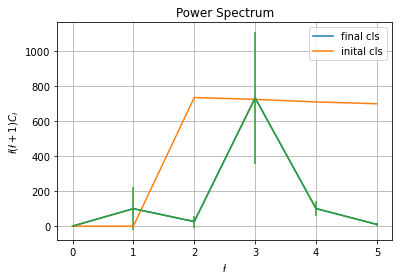

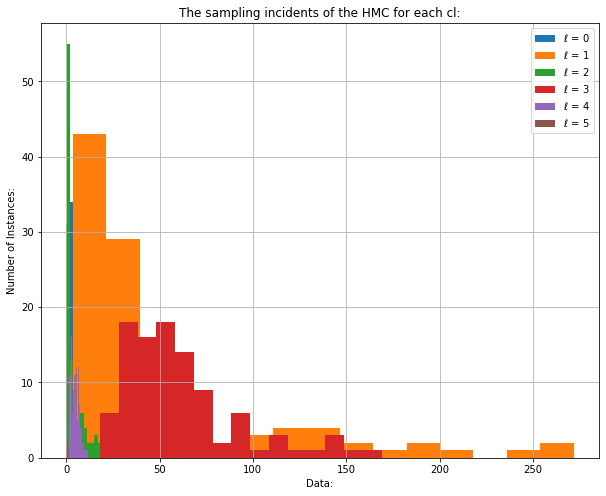

In [130]:
lncl_samples = tf.slice(samples2,[0,0],[100,6]) #The sampled cls from the adaptive step size HMC
cl_samples = tf.math.exp(lncl_samples)
mean_cl = [tf.math.reduce_mean(cl_samples[:,i])  for i in range(lmax4)] #The mean of the sampled cls from the adaptive step size HMC
std_cl = [tf.math.reduce_std(cl_samples[:,i])  for i in range(lmax4)] #The standard deviation of the = sampled cls from the adaptive step size HMC
plt.figure()
plotpwrspctrm(mean_cl) # Plot of the mean sampled cls
plotpwrspctrm(cls4) #Plot of the original cls
ell = np.arange(lmax4)
plt.errorbar(ell,(ell*(ell+1)*mean_cl),xerr = 0, yerr = (ell*(ell+1)*std_cl))
plt.grid()
plt.legend(('final cls','inital cls'))
plt.show()

plt.figure(figsize = [10,8])
[plt.hist((cl_samples[:,i].numpy()), bins = 15) for i in range(lmax4)] #Histogram of the sampled cls for each l value.
plt.legend((r'$\ell$ = 0','$\ell$ = 1','$\ell$ = 2','$\ell$ = 3','$\ell$ = 4','$\ell$ = 5'))
plt.grid()
plt.xlabel('Data:')
plt.ylabel('Number of Instances:')
plt.title('The sampling incidents of the HMC for each cl:')
plt.show()


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will 

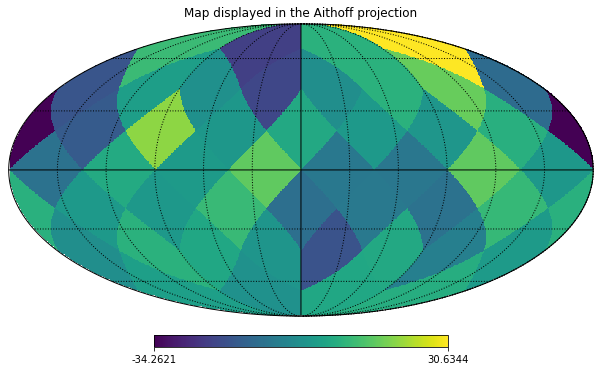

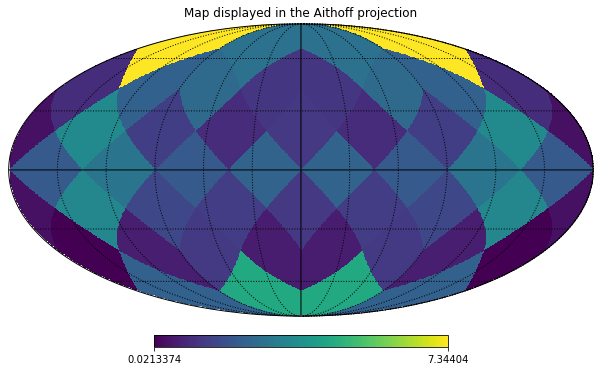

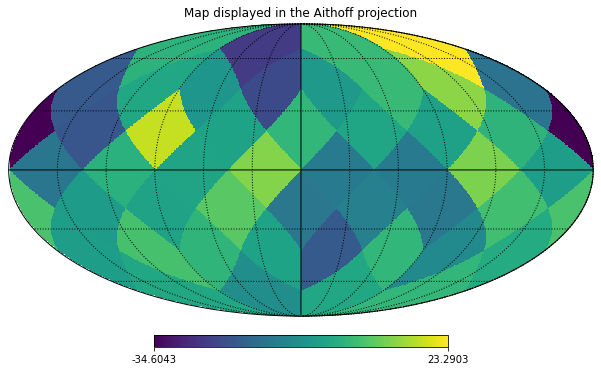

In [131]:
ralm_samples = tf.slice(samples2,[0,6],[100,21]) #The real alm samples from the adaptive step size HMC
ialm_samples = tf.slice(samples2,[0,27],[100,21]) #The imaginary alm samples from the adaptive step size HMC
mean_ralm = [tf.math.reduce_mean(ralm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the real alms
mean_ialm = [tf.math.reduce_mean(ialm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the imaginary alms
std_ralm = [tf.math.reduce_std(ralm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the real alms
std_ialm = [tf.math.reduce_std(ialm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the imaginary alms
mean_alm = splittosingularalm_tf(mean_ralm, mean_ialm) 
mean_map = almtomap_tf(mean_alm,np.int(lmax4/3)) #The mean samples from the HMC as a map

mollviewmap(map4) #Plot of the original map
mollviewmap(mean_map.numpy()) #Plot of the mean samples from the HMC as a map
mollviewmap(map4 - mean_map.numpy()) #A plot of the difference between the original and sampled maps.

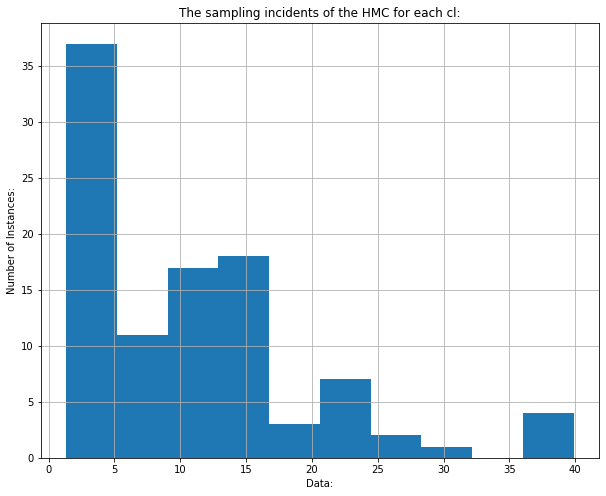

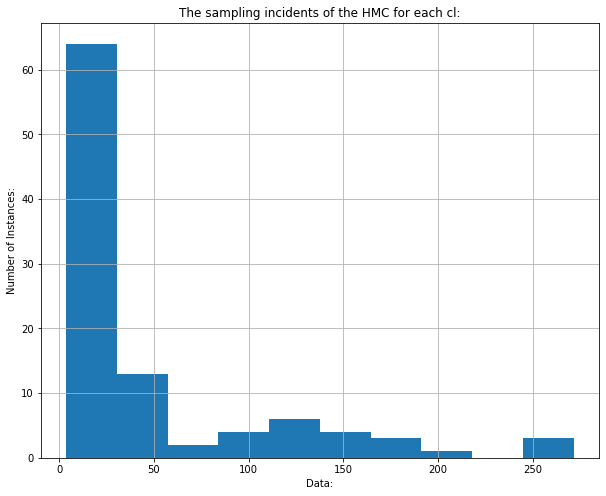

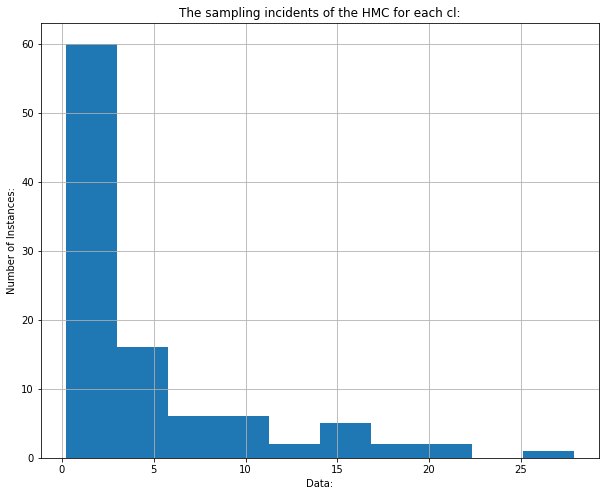

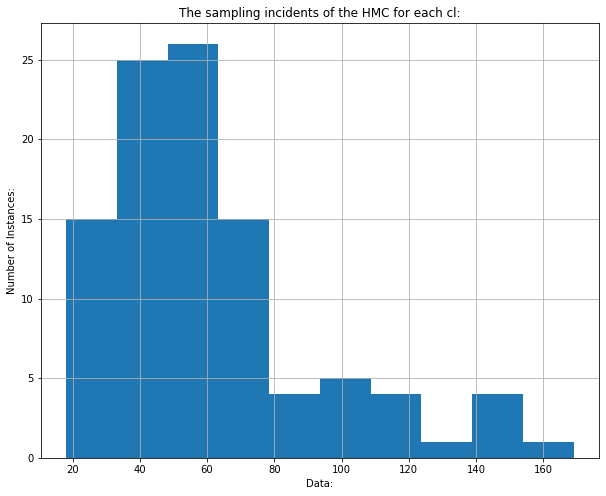

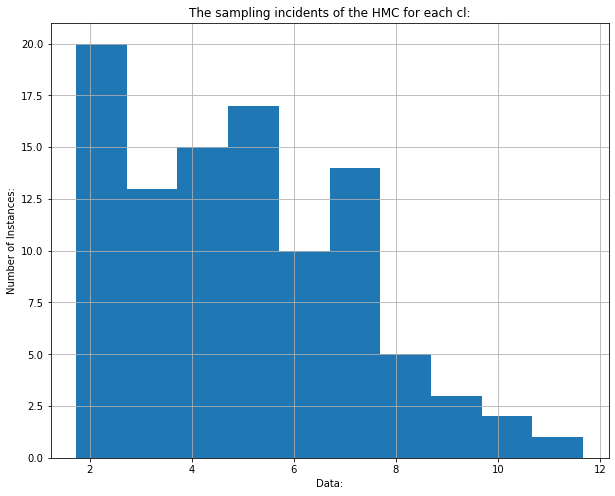

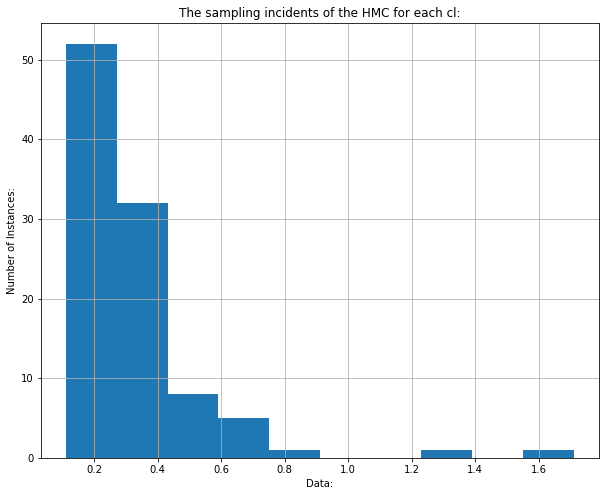

In [134]:
for i in range(lmax4):
    plt.figure(figsize = [10,8])
    plt.hist((cl_samples[:,i].numpy()))  #Histogram of the sampled cls for each l value.
    plt.grid()
    plt.xlabel('Data:')
    plt.ylabel('Number of Instances:')
    plt.title('The sampling incidents of the HMC for each cl:')
    plt.show()

In [ ]:
#[insert here where your maps are coming from]


# loop over samples (what we want!)
#saves the frames:
i = 0
for s in Maps:
    # s[0] is the first bin!
    hp.mollview(s[1][0], min=-0.0115, max=0.0115, title="Bin 2 - $\kappa_1$ ")
    N = str(i).zfill(3)
    plty.savefig(f'/path/to/saving/frames/Kappa_2-frame-{N}.png', bbox_to_inches='tight')
    plty.close()
    i += 1

# Creates the gif:
# filepaths
fp_in = "/path/to/saving/frames/Kappa_2-frame-*.png"
fp_out = "/path/to/saving/gifs/kappa_2.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=80, loop=0, optimize=False)
